In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import random
import tensorflow as tf
from abc import ABC, abstractclassmethod
pd.options.mode.chained_assignment = None
import sys
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from timeit import default_timer as timer

In [2]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [3]:
class ModelFramework(ABC):
    @abstractclassmethod
    def __init__(self):
        self._model = tf.keras.Sequential()
        self._model_name = "DEFAULT_NAME"
        self._checkpointer = None
        self._tensorboard = None
        self._preprocessor = None
        self._train_x = []
        self._train_y = []
        self._test_x = []
        self._test_y = []
        self._results = None
        self._input_shape = ()
        self._output_shape = ()
        self._train_time = 0

    @abstractclassmethod
    def build_model(self):
        pass
    
    @abstractclassmethod
    def pre_process(self):
         pass

    @abstractclassmethod
    def train(self):
        pass

    @abstractclassmethod
    def get_performance_metrics(self):
        pass

    def __call__(self, inputs):
        return self._model(inputs)

    def test(self):
        self._results = self._model.evaluate(self._test_x, self._test_y, batch_size=100)
        print(self._model_name, "\n===============\n",self._model.metrics_names, "\n===============\n" ,self._results, "\n===============\n")

    def set_model(self, model):
        self._model = model
        self.set_input_shape()
        self.set_output_shape()

    def get_model(self):
        return self._model

    def set_input_shape(self):
        self._input_shape = self._train_x.shape
    
    def set_output_shape(self):
        for layer in self._model.layers:
            shape = layer.output_shape
        self._output_shape = shape

    def get_input_shape(self):
        return self._input_shape

    def get_output_shape(self):
        return self._output_shape

    def get_train(self):
        return self._train_x, self._train_y

    def get_test(self):
        return self._test_x, self._test_y

    def get_preprocessor(self):
        return self._preprocessor

In [4]:
class DataPreProcessor:
    def __init__(self, dataframe, include_features=[], predict=["DL_bitrate"], use_predict=True, manual_mode=False, scaler=None, scaler_file_name="univarte_scaler.sav", random_seed=130, history=10, horizon=5):

        # Metadata
        metadata = ["Timestamp", "session", "movement_type"]
        self.__random_seed = random_seed
        self.__history_length = history
        self.__horizon_length = horizon
        
        # Working dataframes
        self.__df = dataframe[include_features+predict+metadata]
        self.__train = None
        self.__test = None

        # Predict variables
        self.__predict = predict
        self.__use_predict = use_predict

        # Numeric features
        self.__numeric_features = ["SNR", "CQI", "RSSI", "NRxRSRP", \
            "NRxRSRQ", "ServingCell_Distance", "Speed", "RSRQ", "RSRP", "DL_bitrate", "UL_bitrate"]
        self.__numeric_features = [i for i in self.__numeric_features if i in include_features and i in self.__numeric_features]
        if use_predict:
            for i in predict:
                if i not in self.__numeric_features:
                    self.__numeric_features.append(i)
        
        # Geological features
        self.__geo_features = ["Longitude", "Latitude", "ServingCell_Lon", "ServingCell_Lat"]
        self.__geo_features = [i for i in self.__geo_features if i in self.__geo_features and i in include_features]

        # Categorical features
        self.__categorical_features = list(set(self.__df.drop(columns=["Timestamp"])).difference(\
            self.__df[self.__numeric_features+self.__geo_features]))
        self.__categorical_features = [i for i in self.__categorical_features if i in self.__categorical_features and i in include_features]

        # Basic formatting
        self.__df = self.__df.replace({"-": np.nan, "": np.nan})
        try:
            self.__df["Timestamp"] = pd.to_datetime(self.__df["Timestamp"],
             format="%Y.%m.%d_%H.%M.%S")
        except Exception as e:
            pass
        # Potential memory issue with float64
        self.__df[self.__numeric_features+self.__geo_features] \
            = self.__df[self.__numeric_features+self.__geo_features].astype("float64")
        if self.__use_predict:
            numeric_features = self.__numeric_features[:-(len(self.__predict))]
        new_order = self.__predict + numeric_features + self.__geo_features + self.__categorical_features + metadata
        self.__df = self.__df.reindex(columns=new_order)
        
        # Geographic features imputed using foward fill
        if self.__geo_features:
            self.__df[self.__geo_features] = self.__df[self.__geo_features].fillna(method="ffill")
        # Categorical features imputed using most frequent
        if self.__categorical_features:
            self.__df[self.__categorical_features].fillna(self.__df[self.__categorical_features].mode().iloc[0], inplace=True)

        # Output variables for use in models
        self.__features = []

        self.__scaler = scaler
        self.__scaler_length = 0
        self.__scaler_file_name = scaler_file_name
        self.__x_train= []
        self.__y_train = []
        self.__x_test = []
        self.__y_test = []
        # For Multi-stage Models
        # Train
        self.__x_train_low = []
        self.__y_train_low = []
        self.__x_train_medium = []
        self.__y_train_medium = []
        self.__x_train_high = []
        self.__y_train_high = []
        # Test
        self.__x_test_low = []
        self.__y_test_low = []
        self.__x_test_medium = []
        self.__y_test_medium = []
        self.__x_test_high = []
        self.__y_test_high = []

        # Labels for basic predictor model
        self.__label_dict = {"low": (1,0,0), "medium": (0,1,0), "high": (0,0,1)}

        # Train
        self.__y_train_labels = []
        # Sequence, targets after balancing
        self.__x_train_balanced = []
        self.__y_train_balanced = []

        # Test
        self.__y_test_labels = []
        # Sequence, targets after balancing
        self.__x_test_balanced = []
        self.__y_test_balanced = []

        if not manual_mode:
            self.do_all_preprocessing()

    def do_all_preprocessing(self):
            self.train_test_split()
            if self.__categorical_features:
                self.one_hot_encode()
                print("Categorical Features Included!!")
            self.__train = self.impute_and_normalise(dataframe=self.__train)
            self.__test = self.impute_and_normalise(dataframe=self.__test, test=True, scaler=self.__scaler)
            self.__train = self.create_averaged_features(dataframe=self.__train)
            self.__test = self.create_averaged_features(dataframe=self.__test)
            self.__x_train, self.__y_train = self.create_sequences(self.__train, self.__history_length, self.__horizon_length)
            self.__x_test, self.__y_test = self.create_sequences(self.__test, self.__history_length, self.__horizon_length)
            self.__y_train_labels = self.create_labels(self.__y_train)
            self.__y_test_labels = self.create_labels(self.__y_test)
            self.__x_train_balanced, self.__y_train_balanced = self.balance_labels(self.__x_train, self.__y_train_labels)
            self.__x_test_balanced, self.__y_test_balanced = self.balance_labels(self.__x_test, self.__y_test_labels, train=False)
            self.separate_by_label(train=True)
            self.separate_by_label(train=False)
            self.save_scaler()

    def train_test_split(self, train_prop=0.8):
        no_of_traces = self.__df["session"].max()+1
        train_size = round(no_of_traces*train_prop)
        random.seed(self.__random_seed)
        sample = random.sample(range(no_of_traces), train_size)
        train = pd.DataFrame()
        for i in sample:
            trace = self.__df[self.__df["session"]==i]
            train = pd.concat([train,trace], axis=0)
        self.__train = train
        self.__test = self.__df.drop(self.__train.index)

    # TODO : Handle the situation where train and test have different categorical features,
    #        as sequences must be consistent in length and column position
    def one_hot_encode(self):
        categorical_features = self.__categorical_features+["Timestamp"]
        cols = [i for i in self.__df.columns if i not in categorical_features]
        self.__df[cols] = self.__df[cols].astype("float64")
        self.__df = pd.get_dummies(self.__df)
        self.__categorical_features = list(set(self.__df.drop(columns=["Timestamp"])).difference(\
            self.__df[self.__numeric_columns+self.__geo_columns]))
    
    def impute_and_normalise(self, dataframe, test=False, scaler=None, return_true_values=False):
        # IMPORTANT: See Data_Expolration notebook for reasoning on imputation choices

        # Is a scaler provided? If no and this is test data then throw an error.
        if not scaler:
            if test:
                print("Error, test data must use a prior scaler created on the training data.")
                return None
            # scaler = MinMaxScaler((-1,1))
            scaler = RobustScaler()
        
        if "CQI" in self.__numeric_features:
            dataframe["CQI"].fillna(dataframe["CQI"].min(), inplace=True)
        
        if "SNR" in self.__numeric_features:
            dataframe["SNR"].fillna(dataframe["SNR"].min(), inplace=True)

        if "RSSI" in self.__numeric_features:
            dataframe["RSSI"].fillna(dataframe["RSSI"].min(), inplace=True)

        # Checking to see if the y variable is being used to predict itself.
        if self.__use_predict:
            x_data = dataframe[self.__predict+self.__numeric_features[:-(len(self.__predict))]+self.__geo_features+self.__categorical_features]
        else:
            x_data = dataframe[self.__numeric_features+self.__geo_features+self.__categorical_features]
        new_values = scaler.fit_transform(x_data)

        # NRxRSRP and NRxRSRQ require KNN-Imputation.
        require_KNN = ["NRxRSRP", "NRxRSRQ", "RSRP", "RSRQ"]
        require_KNN = [i for i in require_KNN if i in self.__numeric_features]
        if require_KNN:
            imputer = KNNImputer(n_neighbors=5)
            new_values = imputer.fit_transform(new_values)

        # Require the original values
        if return_true_values:
            new_values = scaler.inverse_transform(new_values)

        # Reasssigning scaled and imputed data to the dataframe
        dataframe[self.__numeric_features] = new_values
        dataframe[self.__numeric_features].astype("float64")
        if not test:
            self.__scaler = scaler
            self.__scaler_length = len(x_data.columns)
        return dataframe

    # MORE THOUGHT NEEDED ON USAGE
    def scale(self, dataframe, test=False, scaler=None):
        if not scaler:
            if test:
                print("Error, test data must use a prior scaler created on the training data.")
                return None
            scaler = MinMaxScaler()
        if self.__use_predict:
            x_data = dataframe[self.__predict+self.__numeric_features[:-(len(self.__predict))]+self.__geo_features+self.__categorical_features]
        else:
            x_data = dataframe[self.__numeric_features+self.__geo_features+self.__categorical_features]
        scaler_length = len(x_data.columns)
        normalised_x_data = scaler.fit_transform(x_data)
        dataframe[self.__numeric_features] = normalised_x_data
        dataframe[self.__numeric_features].astype("float64")
        if not test:
            self.__scaler = scaler
            self.__scaler_length = scaler_length
        return dataframe

    def create_averaged_features(self, dataframe, history_window=5):
        potential_features = ["SNR", "CQI", "RSSI", "NRxRSRQ", "NRxRSRP", "RSRP", "RSRQ"]
        features_to_average = [i for i in potential_features if i in self.__numeric_features and i in potential_features]
        updated_features = pd.DataFrame()
        groups = dataframe.groupby("session")
        for name, group in groups:
            group[features_to_average] = group[features_to_average].ewm(span=history_window, adjust=True).mean()
            updated_features = pd.concat([updated_features, group[features_to_average]], axis=0)
        dataframe[features_to_average] = updated_features
        return dataframe
    
    def create_sequences(self, dataframe, history_length, horizon_length):
        if self.__history_length == 0 and self.__horizon_length == 0:
            if history_length != self.__history_length or horizon_length != self.__horizon_length:
                self.__history_length = history_length
                self.__horizon_length = horizon_length
        # x, y are lists of dataframes
        x = []
        y = []
        if dataframe.empty:
            dataframe = self.__df.copy()
        dataframe = dataframe.drop(columns=["movement_type", "Timestamp"])
        try:
            groups = dataframe.groupby("session")
        except Exception as e:
            dataframe["session"] = 0
            groups = dataframe.groupby("session")
        numeric_features = self.__numeric_features
        # Checking if feature is used to predict itself
        if self.__use_predict:
            numeric_features = self.__numeric_features[:-(len(self.__predict))]
        new_order = self.__predict + numeric_features + self.__geo_features + self.__categorical_features
        for name, group in groups:
            x_sequences = []
            y_sequences = []
            group = group.drop(columns=["session"])
            data = group.reindex(columns=new_order)
            self.__features = list(group.columns)
            for i in range(self.__history_length, len(data)-self.__horizon_length+1):
                x_sequences.append(data[i-self.__history_length:i])
                y_sequences.append(data[self.__predict][i:i+self.__horizon_length])
            x = x + x_sequences
            y = y + y_sequences
        return x, y

    def create_labels(self, y_sequences=[], scaled=True):
        y_labels = []
        y_sequences = np.array(y_sequences)
        for sequence in y_sequences:
            # adding columns to the np.array to match the shape used in the scaler.
            diff = self.__scaler_length - sequence.shape[1]
            if diff > 0:
                transform = np.zeros((sequence.shape[0],self.__scaler_length))
                transform[:,:-diff] = sequence
            else: 
                transform = sequence
            if scaled:
                transform = self.__scaler.inverse_transform(transform)
            # FOR NOW ASSUMING DL_bitrate IS THE ONLY FACTOR USED TO LABEL FUTURE THROUGHPUT
            # ALSO ASSUMES THAT DL_bitrate IS ALWAYS FIRST ITEM IN self.__predict
            average_throughput = (sum(transform[0])/len(transform[0]))/1000
            if average_throughput < 1:
                y_labels.append(self.__label_dict["low"])
            elif average_throughput > 3:
                y_labels.append(self.__label_dict["high"])
            else:
                y_labels.append(self.__label_dict["medium"])
        return y_labels

    def balance_labels(self, x_sequences, labels, train=True, ignore_min_size=True):
        # PROBABLY DONT NEED TO BALANCE TEST SET
        low_x = []
        medium_x = []
        high_x = []
        low_y = []
        medium_y = []
        high_y = []
        for sequence, target in zip(x_sequences, labels):
            if target[0] == 1:
                low_x.append(sequence)
                low_y.append(target)
            elif target[1] == 1:
                medium_x.append(sequence)
                medium_y.append(target)
            else:
                high_x.append(sequence)
                high_y.append(target)
        minimum = min(len(low_y), len(medium_y), len(high_y))
        if not ignore_min_size:
            if train:
                if minimum < 22000:
                    print("Minimum no. of examples of a label is", minimum)
                    print("training datasets are too small, rerunning preprocessing for better mix of data.")
                    self.do_all_preprocessing()
                    # Above function will continue to be run until values below meet the criteria.
                    return self.__x_train_balanced, self.__y_train_balanced
            # Test set is too small.
            else:
                if minimum < 4000:
                    print("Minimum no. of examples of a label is", minimum)
                    print("test datasets too small, rerunning preprocessing for better mix of data.")
                    self.do_all_preprocessing()
                    return self.__x_test_balanced, self.__y_test_balanced
        low_x = low_x[:minimum]
        low_y = low_y[:minimum]
        medium_x = medium_x[:minimum]
        medium_y = medium_y[:minimum]
        high_x = high_x[:minimum]
        high_y = high_y[:minimum]
        x = low_x + medium_x + high_x
        y = low_y + medium_y + high_y
        return x, y

    def separate_by_label(self, train=True):
        low_x = []
        medium_x = []
        high_x = []
        low_y = []
        medium_y = []
        high_y = []
        label_dict = {}
        for key in self.__label_dict:
            val = self.__label_dict[key]
            label_dict[val] = key

        if train:
            x_sequences = self.__x_train
            y_sequences = self.__y_train
            labels = self.__y_train_labels
        else:
            x_sequences = self.__x_test
            y_sequences = self.__y_test
            labels = self.__y_test_labels

        for i in range(len(labels)):
            if label_dict[labels[i]] == "low":
                low_x.append(x_sequences[i])
                low_y.append(y_sequences[i])
            elif label_dict[labels[i]] == "medium":
                medium_x.append(x_sequences[i])
                medium_y.append(y_sequences[i])
            else:
                high_x.append(x_sequences[i])
                high_y.append(y_sequences[i])

        if train:
            self.__x_train_low = low_x
            self.__y_train_low = low_y
            self.__x_train_medium = medium_x
            self.__y_train_medium = medium_y
            self.__x_train_high = high_x
            self.__y_train_high = high_y
        else:
            self.__x_test_low = low_x
            self.__y_test_low = low_y
            self.__x_test_medium = medium_x
            self.__y_test_medium = medium_y
            self.__x_test_high = high_x
            self.__y_test_high = high_y

    def get_test_sequences(self):
        return np.array(self.__x_test), np.array(self.__y_test)

    def get_train_sequences(self):
        return np.array(self.__x_train), np.array(self.__y_train)

    def get_label_predictor_train(self):
        return np.array(self.__x_train_balanced), np.array(self.__y_train_balanced, ndmin=2)

    def get_label_predictor_test(self):
        return np.array(self.__x_test_balanced), np.array(self.__y_test_balanced, ndmin=2)

    def get_low_train_sequences(self):
        return np.array(self.__x_train_low), np.array(self.__y_train_low)

    def get_medium_train_sequences(self):
        return np.array(self.__x_train_medium), np.array(self.__y_train_medium)

    def get_medium_test_sequences(self):
        return np.array(self.__x_test_medium), np.array(self.__y_test_medium)

    def get_high_train_sequences(self):
        return np.array(self.__x_train_high), np.array(self.__y_train_high)

    def get_low_test_sequences(self):
        return np.array(self.__x_test_low), np.array(self.__y_test_low)

    def get_high_test_sequences(self):
        return np.array(self.__x_test_high), np.array(self.__y_test_high)

    def get_label_dict(self):
        return self.__label_dict

    def get_history_length(self):
        return self.__history_length

    def get_horizon_length(self):
        return self.__horizon_length

    def get_feature_order(self):
        return self.__features

    def save_scaler(self, filename=None):
        if not filename:
            filename = self.__scaler_file_name
        filepath = "C:\\Users\\Killian\\Desktop\\FYP-Multistage-Throughput-Predictor\\src\\saved.objects\\"+filename
        pickle.dump(self.__scaler, open(filepath, "wb"))

In [5]:
class SimpleLSTM(ModelFramework):
    def __init__(self, raw_data=pd.DataFrame(), model_name="lstm_univariate"):
        super().__init__()
        self._raw_data = raw_data
        self._model_name = model_name

    def pre_process(self, preprocessed=False,train=[], test=[], include_features=[], predict=["DL_bitrate"], use_predict=True, manual_mode=False, scaler=None):
        if preprocessed:
            if train and test:
                self._train_x = train[0]
                self._train_y = train[1]
                self._test_x = test[0]
                self._test_y = test[1]
            else:
                print("Error. Expected train and test sequences to be given in format:\n", "train=[train_x, train_y]\ntest=[test_x, test_y]")
        else:
            scaler_file_name = self._model_name + ".sav"
            self._preprocessor = DataPreProcessor(self._raw_data, include_features=include_features, predict=predict,
             use_predict=use_predict, manual_mode=manual_mode, scaler=scaler, scaler_file_name=scaler_file_name)
            self._train_x, self._train_y = self._preprocessor.get_train_sequences()
            self._test_x, self._test_y = self._preprocessor.get_test_sequences()

    def build_model(self):
        self._model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128, input_shape=(self._train_x.shape[1], self._train_x.shape[2]), return_sequences=True))
        self._model.add(tf.keras.layers.Dropout(.3))
        self._model.add(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True))
        self._model.add(tf.keras.layers.Dropout(.3))
        self._model.add(tf.compat.v1.keras.layers.CuDNNLSTM(32, return_sequences=False))
        self._model.add(tf.keras.layers.Dropout(.3))
        self._model.add(tf.keras.layers.Dense(self._train_y.shape[1], name="OUT_{}".format(self._model_name)))
        self._model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
        self._model.summary()
        self.set_input_shape()
        self.set_output_shape()

    def train(self, epochs=10, batch_size=100, validation_split=0.2):
        timer = TimingCallback()
        self._tensorboard = TensorBoard(log_dir="C:\\Users\\Killian\\Desktop\\FYP-Multistage-Throughput-Predictor\\src\\logs\\{}".format(self._model_name))
        self._checkpointer = ModelCheckpoint(filepath='C:\\Users\\Killian\\Desktop\\FYP-Multistage-Throughput-Predictor\\src\\saved.objects\\{}.hdf5'.format(self._model_name), verbose = 1, save_best_only=True)
        self._model.fit(self._train_x, self._train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1, callbacks=[self._checkpointer, self._tensorboard, timer])
        self._train_time = sum(timer.logs)

    def get_performance_metrics(self):
        return self._train_time

In [6]:
DATASETS_FOLDER_PATH = "C:/Users/Killian/Desktop/FYP-Multistage-Throughput-Predictor/Datasets/Raw/"
raw_data_path = DATASETS_FOLDER_PATH + "all_4G_data.csv"

raw_data = pd.read_csv(raw_data_path, index_col=None)

C:\Users\Killian\AppData\Local\Temp\ipykernel_4040\1448511203.py:4: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(raw_data_path, index_col=None)


In [7]:
model = SimpleLSTM(raw_data, "feature_importance_model")
model.pre_process(include_features=["RSRQ", "RSRP", "CQI", "SNR", "UL_bitrate", "NRxRSRP", "NRxRSRQ"])

In [8]:
model.build_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 10, 128)           70656     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 10, 64)            49664     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 32)                12544     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 OUT_feature_importance_mode  (None, 5)                

In [9]:
model.train()

Epoch 1/10
1095/1098 [============================>.] - ETA: 0s - loss: 0.3040 - mean_absolute_error: 0.3281
Epoch 1: val_loss improved from inf to 0.17556, saving model to C:\Users\Killian\Desktop\FYP-Multistage-Throughput-Predictor\src\saved.objects\feature_importance_model.hdf5
1098/1098 [==============================] - 20s 16ms/step - loss: 0.3039 - mean_absolute_error: 0.3280 - val_loss: 0.1756 - val_mean_absolute_error: 0.1985
Epoch 2/10
1097/1098 [============================>.] - ETA: 0s - loss: 0.2698 - mean_absolute_error: 0.3077
Epoch 2: val_loss did not improve from 0.17556
1098/1098 [==============================] - 17s 15ms/step - loss: 0.2698 - mean_absolute_error: 0.3077 - val_loss: 0.1758 - val_mean_absolute_error: 0.2047
Epoch 3/10
1097/1098 [============================>.] - ETA: 0s - loss: 0.2652 - mean_absolute_error: 0.3056
Epoch 3: val_loss improved from 0.17556 to 0.17281, saving model to C:\Users\Killian\Desktop\FYP-Multistage-Throughput-Predictor\src\saved.

In [10]:
model.test()

355/355 [==============================] - 2s 7ms/step - loss: 0.1641 - mean_absolute_error: 0.2291
feature_importance_model 
 ['loss', 'mean_absolute_error'] 
 [0.1641247421503067, 0.22905367612838745] 



In [11]:
x, y = model.get_test()
preprocessor = model.get_preprocessor()

tf_model = model.get_model()

In [12]:
from tqdm import tqdm
from matplotlib import pyplot as plt

Computing feature importance


100%|██████████| 8/8 [00:36<00:00,  4.60s/it]


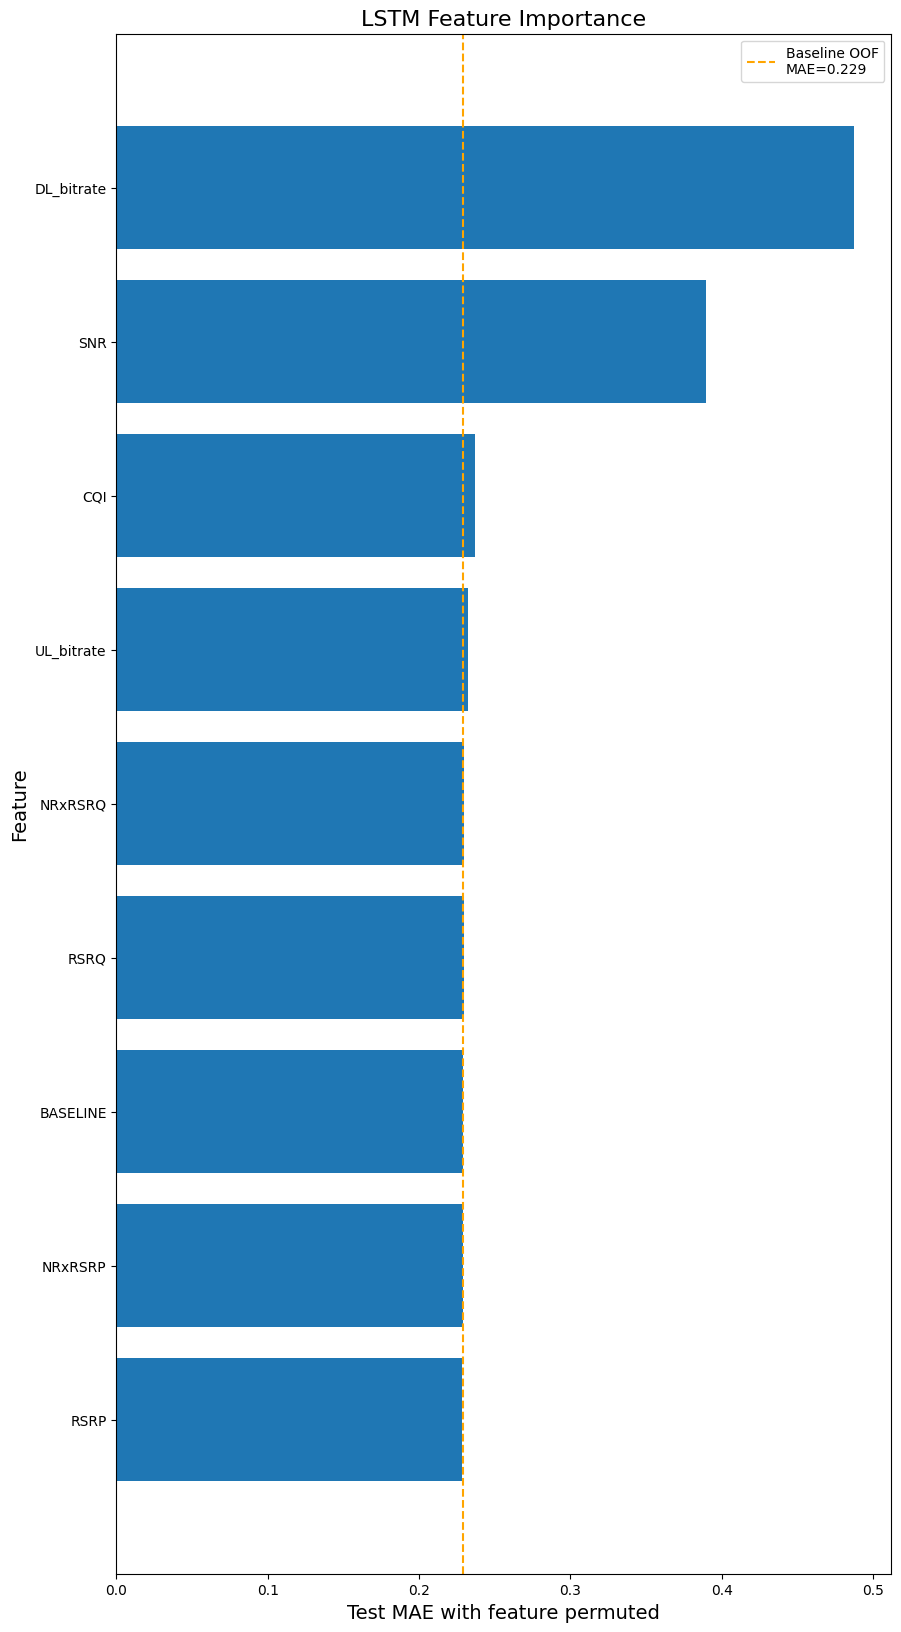

In [13]:
features = preprocessor.get_feature_order()
results = []
print("Computing feature importance")

baseline_preds = tf_model.predict(x, verbose=0).squeeze()
baseline_mae = np.mean(np.abs(baseline_preds-y.squeeze()))
results.append({"feature":"BASELINE", "mae": baseline_mae})

for k in tqdm(range(8)):
    sav_col = x[:,:,k].copy()
    np.random.shuffle(x[:,:,k])
    important_preds = tf_model.predict(x, verbose=0).squeeze()
    mae = np.mean(np.abs(important_preds-y.squeeze()))
    results.append({"feature":features[k], "mae": mae})
    x[:,:,k] = sav_col

result_df = pd.DataFrame(results)
result_df = result_df.sort_values("mae")
plt.figure(figsize=(10,20))
plt.barh(np.arange(len(features)+1),result_df.mae)
plt.yticks(np.arange(len(features)+1),result_df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(features)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(features)+1], '--', color='orange',
            label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
plt.xlabel('Test MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()



# WITH BATCH NORMALISATION MAE= 0.475

# 128, 64 # mae= 0.232 PARAMS = 121,413 # DL_bitrate, SNR, RSRP, NRxRSRQ, RSRQ, UL_bitrate
# 256, 128 mae = 0.228  PARAMS = 470,661 # SNR, DL_bitrate, NRxRSRQ, RSRP
# 128, 64, 32 mae = 0.229 PARAMS = 133,029 DL, SNR, CQI